In [2]:
import torch

import numpy as np
import torch.nn as nn

from architecture.pignn.pignn import FlowPIGNN
from utils.visualization import plot_prediction_vs_real
from architecture.pignn.deconv import FCDeConvNet
from experiments.graphs.graph_experiments import create_data_loaders, get_config, custom_collate_fn, GraphTemporalDataset, GraphDataset

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Load the data from a past experiment
case_nr = 1
max_angle = 90
seq_length = 1
wake_steering = False
use_graph = True
type = "LuT2deg_internal" if wake_steering else "BL"
batch_size = 64
data_folder = f"../../data/Case_0{case_nr}/graphs/{type}/{max_angle}"
dataset = GraphTemporalDataset(root=data_folder, seq_length=seq_length) if seq_length > 1 else GraphDataset(root=data_folder)
model_cfg, train_cfg = get_config(case_nr=case_nr, wake_steering=wake_steering, max_angle=max_angle, use_graph=use_graph, seq_length=seq_length, batch_size=batch_size)
train_loader, val_loader, test_loader = create_data_loaders(dataset, train_cfg['batch_size'], seq_length=seq_length)

In [10]:
print(len(train_loader))

27


In [33]:
import pandas as pd

angles = pd.read_csv("../../data/Case_03/HKN_00_to_03_dir.csv")
print(angles.iloc[:, 1].min())

print(angles.iloc[:, 1].max())

186.93371889024
248.993084183099


In [21]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 906865 parameters without deconv
# 915874 parameters with deconv, conv gives only 1 percent of the params
# 907006 for FCN

In [16]:
# Calculate convolution output sizes
dim_x = 10
dim_y = 50

k = [4, 4, 4]
s = [2, 2, 2]
p = [1, 1, 1]

for i in range(len(k)):
    dim_x = s[i] * (dim_x - 1) + k[i] - 2 * p[i]
    dim_y = s[i] * (dim_y - 1) + k[i] - 2 * p[i]

print(f"{dim_x}  * {dim_y}")

80  * 400


C:\Users\Matth\AppData\Local\Temp\ipykernel_26692\2511716518.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/20241006001755_Cas

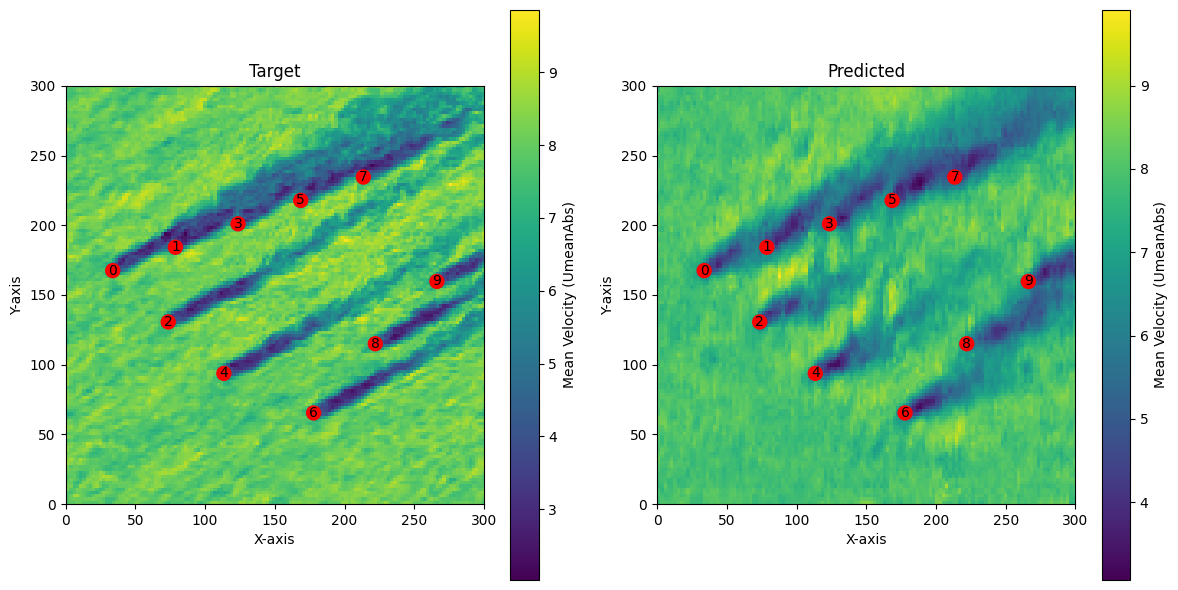

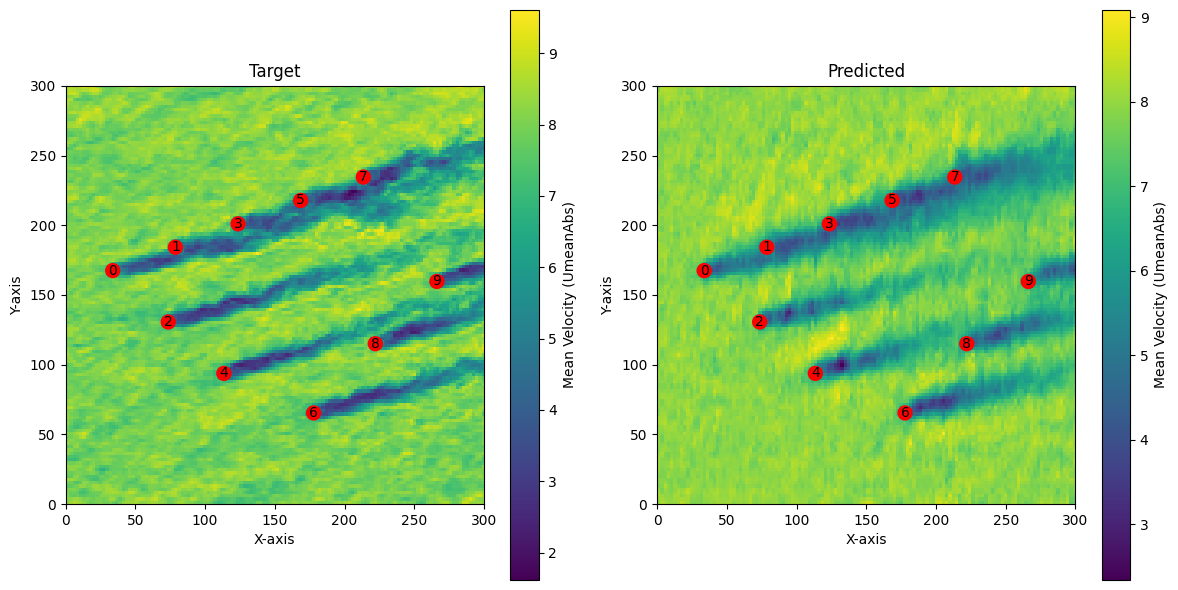

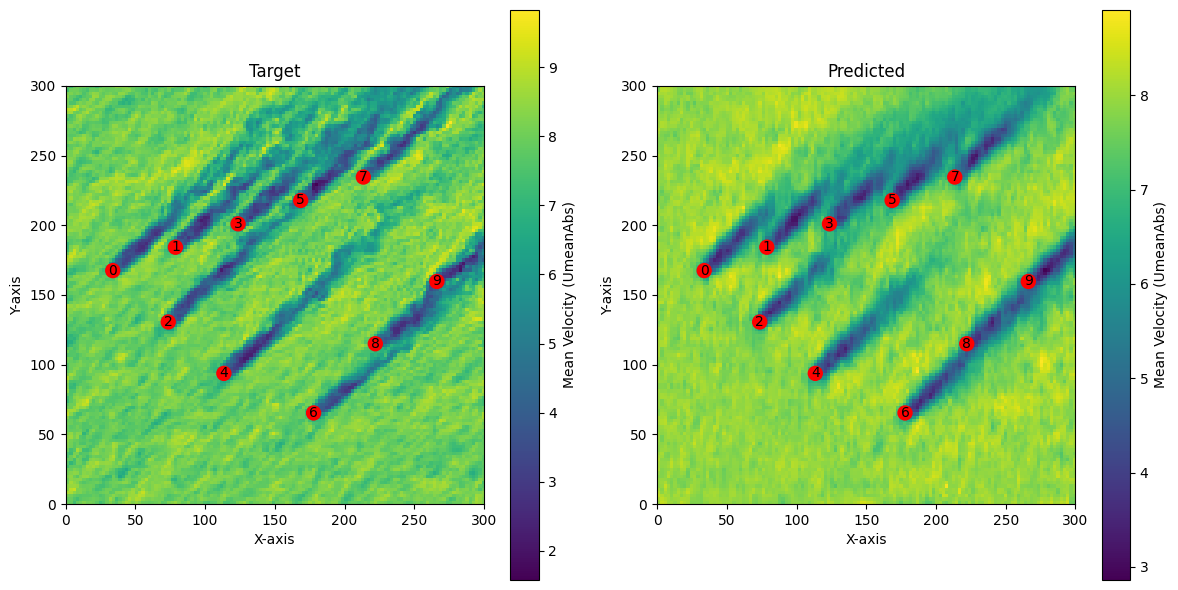

test loss: nan


D:\AI2P\repo\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\AI2P\repo\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
# Plot results for fully connected embedder
model = FCDeConvNet(232, 650, 656, 500).to(device)
model.load_state_dict(torch.load("results/20241006001755_Case01_True_fcn_deconv/pignn_14.pt"))
model.eval()
criterion = nn.MSELoss()

with torch.no_grad():
    test_losses = []
    for i, batch in enumerate(test_loader):
        x = batch.x.to(device)
        pos = batch.pos.to(device)
        edge_attr = batch.edge_attr.to(device)
        glob = batch.global_feats.to(device)
        batch_size = glob.size(0)

        x_cat = torch.cat((
            x.reshape(batch_size, -1),
            pos.reshape(batch_size, -1),
            edge_attr.reshape(batch_size, -1),
            glob.reshape(batch_size, -1)
        ), dim=-1)

        pred = model(x_cat).float()
        target = batch.y.to(device).reshape(-1, pred.size(1))
        test_loss = criterion(pred, target)
        # plot_prediction_vs_real(pred[0, :].reshape(128, 128).cpu(), target[0, :].reshape(128, 128).cpu())

    print(f"test loss: {np.mean(test_losses)}")

C:\Users\Matth\AppData\Local\Temp\ipykernel_26312\2667551181.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/20241012211250_Cas

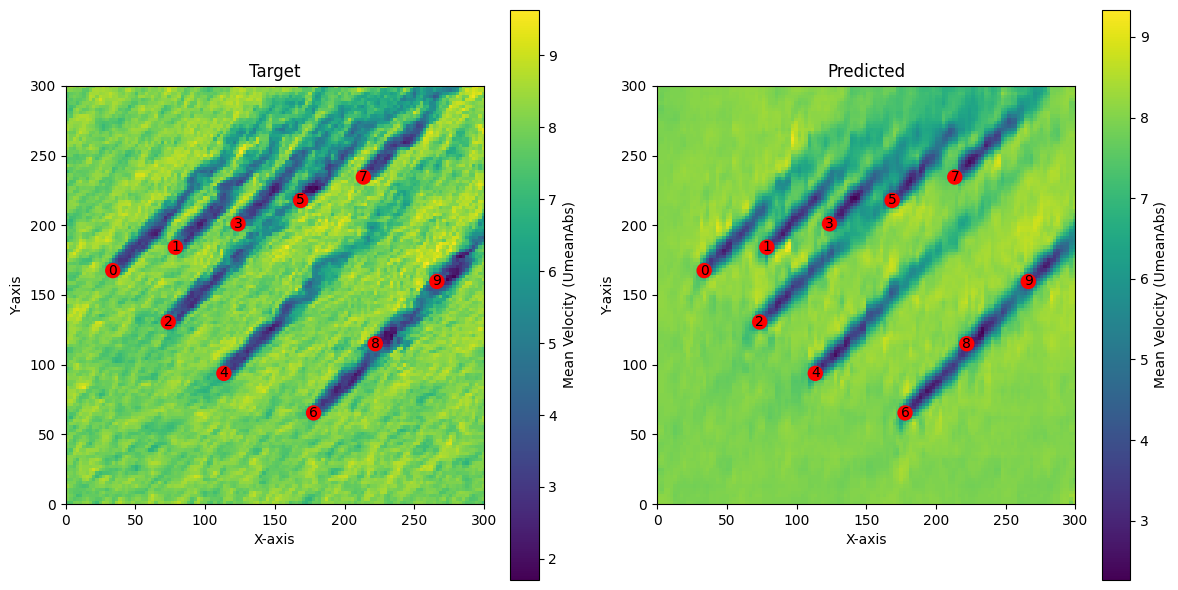

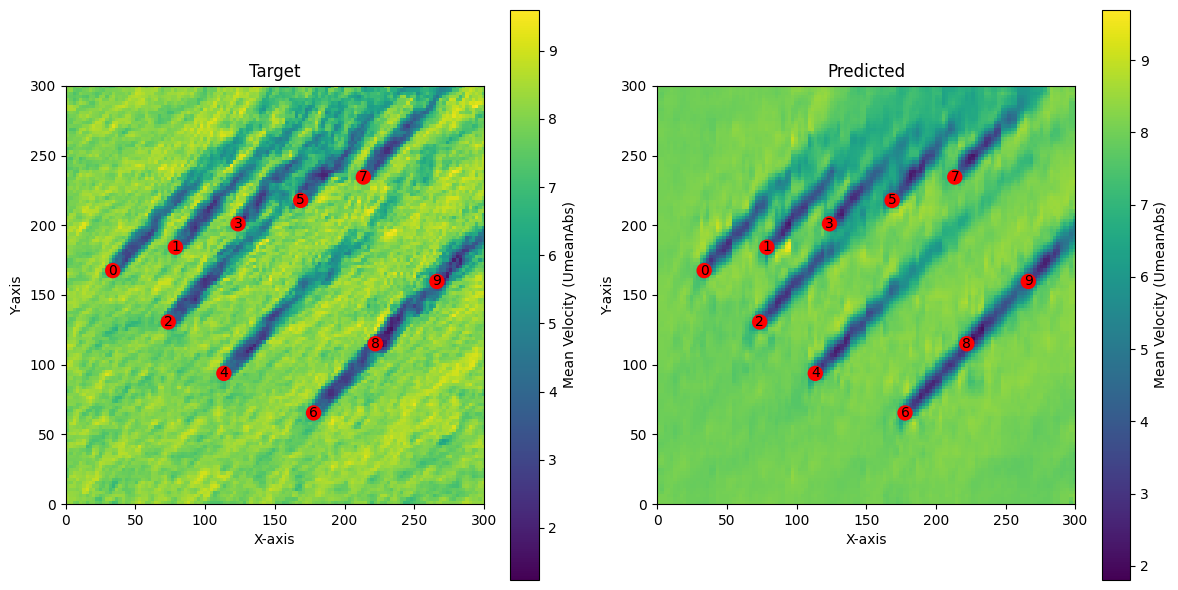

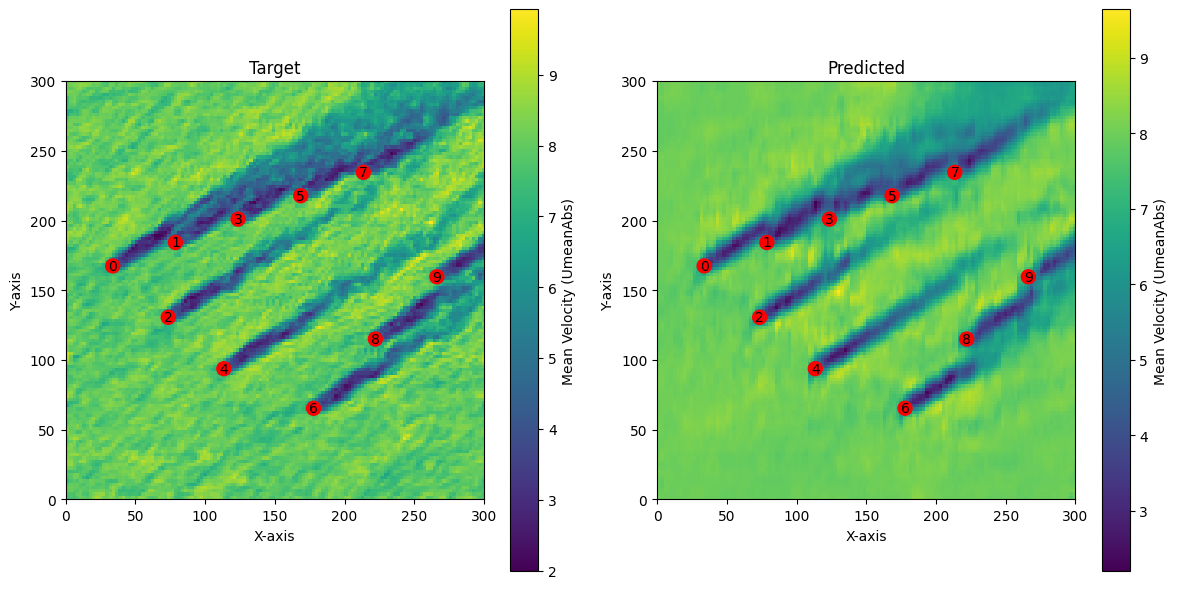

test loss: nan


D:\AI2P\repo\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\AI2P\repo\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
from architecture.pignn.deconv import DeConvNet

# Plot results for PIGNN embedder
actor_model = DeConvNet(1, [128, 256, 1])
model = FlowPIGNN(**model_cfg, actor_model=actor_model).to(device)
model.load_state_dict(torch.load("results/20241012211250_Case01_False_pignn_deconv_90_1/pignn_best.pt"))
model.eval()
image_size = 128
criterion = nn.MSELoss()

with torch.no_grad():
    test_losses = []
    for i, batch in enumerate(test_loader):
        batch = batch.to(device)
        nf = torch.cat((batch.x.to(device), batch.pos.to(device)), dim=-1).float()
        ef = batch.edge_attr.to(device).float()
        gf = batch.global_feats.to(device).float()
        pred = model(batch, nf, ef, gf)
        target = batch.y.to(device).reshape(-1, pred.size(1))
        test_loss = criterion(pred, target)
        # plot_prediction_vs_real(pred[0, :].reshape(image_size, image_size).cpu(), target[0, :].reshape(image_size, image_size).cpu())
        predictions = [
            pred[0, :].reshape(128, 128).cpu(),
            pred[16, :].reshape(128, 128).cpu(),
            pred[32, :].reshape(128, 128).cpu()
        ]

        targets = [
            target[0, :].reshape(128, 128).cpu(),
            target[16, :].reshape(128, 128).cpu(),
            target[32, :].reshape(128, 128).cpu()
        ]

        for i in range(3):
            plot_prediction_vs_real(predictions[i], targets[i], number=i+3)
        break
        test_losses.append(test_loss.item())

    print(f"test loss: {np.mean(test_losses)}")

C:\Users\Matth\AppData\Local\Temp\ipykernel_26692\2301421284.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_model.load_state_dict(torch.load("../../results/202410

50 128


C:\Users\Matth\AppData\Local\Temp\ipykernel_26692\2301421284.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temporal_model.load_state_dict(torch.load("../../results/202

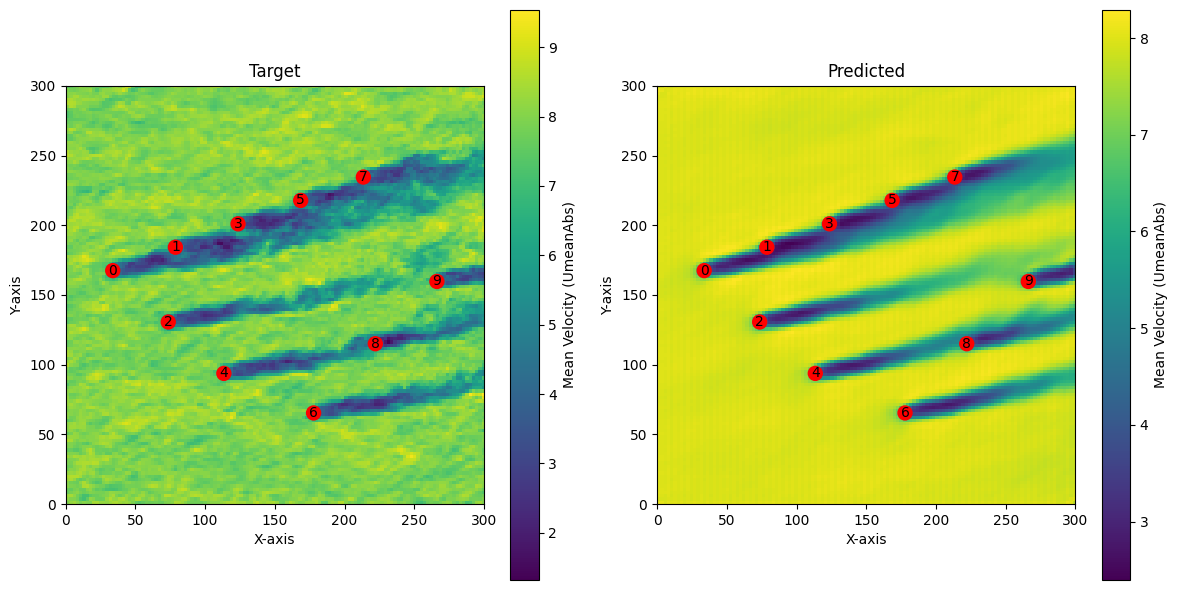

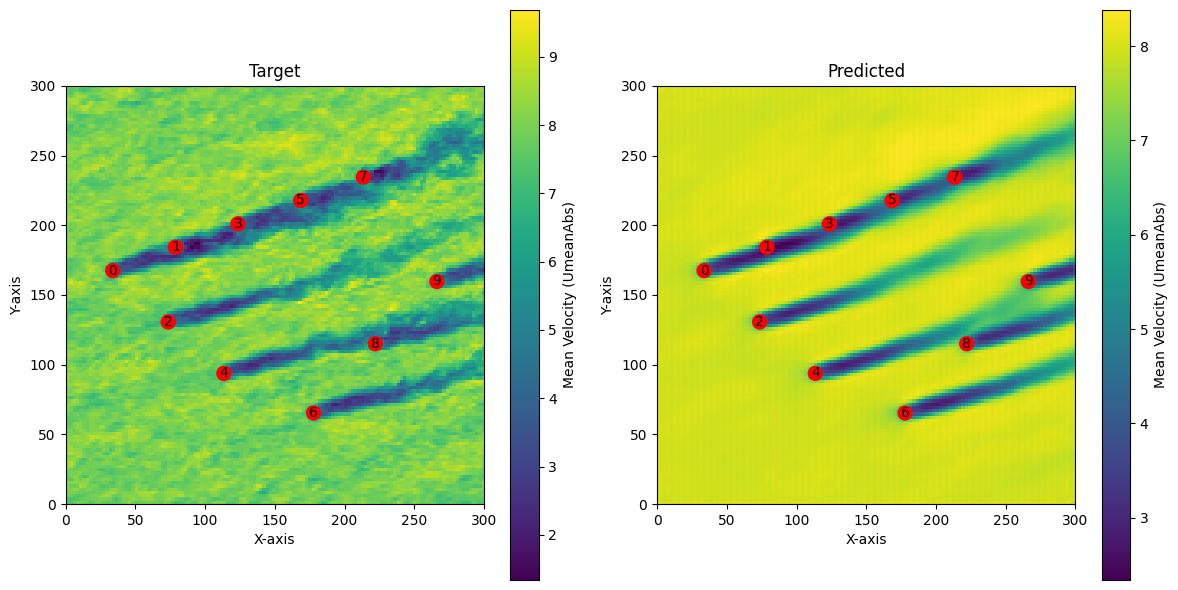

KeyboardInterrupt: 

In [22]:
from utils.visualization import animate_prediction_vs_real
from architecture.windspeedLSTM.windspeedLSTM import WindspeedLSTM

# Plot the result for temporal network
graph_model = FlowPIGNN(**model_cfg).to(device)
graph_model.load_state_dict(torch.load("../../results/20241004121829_Case01_False_pignn_deconv_30_50/pignn_11.pt"))

temporal_model = WindspeedLSTM(seq_length).to(device)
temporal_model.load_state_dict(torch.load("../../results/20241004121829_Case01_False_pignn_deconv_30_50/unet_lstm_11.pt"))

graph_model.eval()
temporal_model.eval()
image_size = 128
criterion = nn.MSELoss()

with torch.no_grad():
    test_losses = []
    for i, batch in enumerate(test_loader):
        generated_img = []
        target_img = []
        for i, seq in enumerate(batch[0]):
            # Process graphs in parallel at each timestep for the entire batch
            seq = seq.to(device)
            nf = torch.cat((seq.x.to(device), seq.pos.to(device)), dim=-1)
            ef = seq.edge_attr.to(device)
            gf = seq.global_feats.to(device)
            graph_output = graph_model(seq, nf, ef, gf).reshape(-1, image_size, image_size)
            generated_img.append(graph_output)
            target_img.append(batch[1][i].y.to(device).reshape(-1, image_size, image_size))

        temporal_img = torch.stack(generated_img, dim=1)
        output = temporal_model(temporal_img).float()
        target = torch.stack(target_img, dim=1)
        test_loss = criterion(output, target)

        plot_prediction_vs_real(output[0, seq_length - 1].cpu(), target[0, seq_length - 1].cpu(), number=i+6)
        test_losses.append(test_loss.item())
    print(f"test loss: {np.mean(test_losses)}")